In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re
import spacy
from collections import Counter
from textblob import TextBlob
from tqdm.notebook import tqdm

In [2]:
reviews = pd.read_csv("../data/raw/all_reviews.csv", low_memory=False)
pd.set_option('display.max_columns', None)


### Initial cleaning

In [3]:
# Function to clean numerical rating columns
def clean_rating_columns(df, columns):
    """
    Clean numerical rating columns by converting them to float and removing invalid entries.
    """
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df = df.dropna(subset=[col])
        df[col] = df[col].astype(float)
    return df

# Function to handle missing values
def handle_missing_values(df, columns_to_fill, fill_value=0.0):
    """
    Fill missing values for specified columns with a given value.
    """
    for col in columns_to_fill:
        df[col] = df[col].fillna(fill_value).astype(float)
    return df

# Function to extract year from date
def extract_year(df, date_column, year_column):
    """
    Extract the year from a date column and create a new year column.
    """
    df[year_column] = df[date_column].str.split().str[2].astype(int)
    df.drop(columns = "date", inplace = True)
    return df[df[year_column] > 2014]

# Function to extract firm names from the firm_link
def extract_firm_names(df, firm_link_column, firm_name_column):
    """
    Extract firm names from firm_link and filter firms with frequent mentions.
    """
    def extract_name(firm_link):
        match = re.search(r'(?<=/)([A-Za-z0-9\-]+)(?=-Reviews)', firm_link)
        return match.group(1) if match else None

    df[firm_name_column] = df[firm_link_column].apply(extract_name)
    df.drop(columns = "firm_link", inplace=True)
    firm_counts = df[firm_name_column].value_counts()
    valid_firms = firm_counts[firm_counts >= 100].index
    
    return df[df[firm_name_column].isin(valid_firms)]

# Function to unify employment statuses
def unify_employment_statuses(df, status_column):
    """
    Standardize employment statuses.
    """
    def unify_status(status):
        if "Current" in status:
            if "Contractor" in status:
                return "Current Contractor"
            elif "Freelancer" in status:
                return "Current Freelancer"
            elif "Intern" in status:
                return "Current Intern"
            elif "Self-employed" in status:
                return "Current Self-employed"
            else:
                return "Current Employee"
        elif "Former" in status:
            if "Contractor" in status:
                return "Former Contractor"
            elif "Freelancer" in status:
                return "Former Freelancer"
            elif "Intern" in status:
                return "Former Intern"
            elif "PhD" in status:
                return "Former PhD"
            elif "Self-employed" in status:
                return "Former Self-employed"
            else:
                return "Former Employee"
        else:
            return "Other"

    df[status_column] = df[status_column].apply(unify_status)
    return df

# Main cleaning function
def clean_dataset(file_path, rating_columns, missing_columns, firm_link_column, status_column, date_column, year_column, job_column):
    """
    Clean the dataset by applying all cleaning functions step by step.
    """
    # Read the data
    df = pd.read_csv(file_path, low_memory=False)
    
    # Clean rating columns
    df = clean_rating_columns(df, rating_columns)
    
    # Drop unnecessary columns
    df.drop(columns=["title", "advice", "index", "Business Outlook"], inplace=True)
    
    # Drop rows with significant missing values
    df.dropna(subset=['pros', 'cons', 'Culture & Values'], inplace=True)

    #Unify names of the columns and reset index
    df['pros'] = df['pros'].str.lower().str.replace(r'\n', ' ', regex=True)
    df['cons'] = df['cons'].str.lower().str.replace(r'\n', ' ', regex=True)
    
    
    # Extract year and filter rows
    df = extract_year(df, date_column, year_column)
    
    # Handle missing values in specific columns
    df = handle_missing_values(df, missing_columns, fill_value=0.0)
    
    # Extract and filter firm names
    df = extract_firm_names(df, firm_link_column, 'firm_name')

    # Unify employment statuses
    df = unify_employment_statuses(df, status_column)
    
    return df

# Usage
file_path = "../data/raw/all_reviews.csv"
rating_columns = ['Work/Life Balance', 'Compensation and Benefits', 'Senior Management', 'Career Opportunities']
missing_columns = ['Diversity & Inclusion']
firm_link_column = 'firm_link'
status_column = 'status'
date_column = 'date'
year_column = 'year'
job_column = 'job'

cleaned_reviews = clean_dataset(
    file_path=file_path,
    rating_columns=rating_columns,
    missing_columns=missing_columns,
    firm_link_column=firm_link_column,
    status_column=status_column,
    date_column=date_column,
    year_column=year_column,
    job_column=job_column
)


/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1370/4252623836.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(float)
/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1370/4252623836.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')


In [4]:
#lowercase column names and replace space by "_"
cleaned_reviews.columns = cleaned_reviews.columns.str.lower().str.replace(" ", "_", regex=True).str.replace("&", "and", regex=True)
cleaned_reviews.reset_index(drop=True, inplace=True)
print(cleaned_reviews.shape)
display(cleaned_reviews.head())

(6016214, 15)


,rating,status,pros,cons,recommend,ceo_approval,career_opportunities,compensation_and_benefits,senior_management,work/life_balance,culture_and_values,diversity_and_inclusion,job,year,firm_name
0,5.0,Current Employee,great life canada i liked,my dream canada working and enjoy the life,v,v,4.0,3.0,4.0,5.0,3.0,4.0,Delivery Post Person With Driving,2023,Canada-Life
1,5.0,Current Employee,best place to work always,system is a bit old,v,v,4.0,4.0,4.0,4.0,4.0,4.0,Manager,2023,Canada-Life
2,1.0,Former Employee,the pro is you get paid... i guess. i worked o...,"just felt like another cog in the machine, wor...",v,v,1.0,1.0,1.0,1.0,1.0,1.0,Customer Service Specialist,2022,Canada-Life
3,1.0,Former Employee,my peers were good to work with. everyone will...,"leadership is not helpful at all, they walk ar...",x,x,1.0,3.0,1.0,2.0,2.0,2.0,Anonymous Employee,2022,Canada-Life
4,4.0,Current Employee,great team with strong focus on personal devel...,company size often results in slow executive d...,v,v,4.0,3.0,4.0,4.0,5.0,5.0,Senior Workplace Strategist,2022,Canada-Life


### Cleaning job titles

In [5]:
def clean_job_titles(df, job_column):
    """
    Clean and standardize job titles in a DataFrame.

    """
    # Replace empty strings or NaN values with "Anonymous Employee"
    df[job_column].replace(' ', 'Anonymous Employee', inplace=True)
    df[job_column].fillna('Anonymous Employee', inplace=True)
    
    # Strip leading/trailing spaces
    df[job_column] = df[job_column].str.strip()
    
    # Count occurrences of each job title
    job_counts = df[job_column].value_counts()
    
    # Filter out jobs mentioned less than 100 times
    valid_jobs = job_counts[job_counts >= 100].index
    df = df[df[job_column].isin(valid_jobs)]
    
    # Replace specific job titles
    job_replacements = {
        'Salees Associate': 'Sales Associate', 'Sales Executive': 'Sales Associate',
        'IT Strategy Consultant': 'IT Consultant',
        'Sales Associate/Cashier': 'Cashier', 'Front End Cashier': 'Cashier',
        'Senior Software Engineer': 'Software Engineer', 
        'Senior Systems Engineer': 'Software Engineer', 
        'Senior Software Developer': 'Software Engineer', 
        'Associate Software Engineer': 'Software Engineer',
        'Sales': 'Sales Associate', 
        'Salees Associate ': 'Sales Associate', 
        'Retail Sales Associate': 'Sales Associate',
        'Sales Assistant': 'Sales Associate', 
        'Sales Representative': 'Sales Associate', 'Inside Sales Representative': 'Sales Associate',
        'Systems Engineer': 'Software Engineer', 'Senior Engineer':'Software Engineer',
        'Senior Associate': 'Associate', 
        'Senior Analyst ': 'Analyst',
        'Business Analyst': 'Analyst', 'Senior Business Analyst ': 'Analyst','Senior Business Analyst': 'Analyst', 'Financial Analyst': 'Analyst',
        'IT Analyst': 'Analyst', 'Senior Analyst': 'Analyst', 'Programmer Analyst': 'Analyst',
        'Server': 'Waiter/Waitress', 'Waiter': 'Waiter/Waitress', 'Waitress': 'Waiter/Waitress',
        'Warehouse Worker': 'Warehouse Associate',
        'Human Resources': 'HR', 
        'Recruiter': 'HR',
        'Customer Service Representative': 'Customer Service', 
        'Customer Service Representative (CSR)': 'Customer Service', 'Customer Service Specialist': 'Customer Service',
        'Customer Assistant': 'Customer Service', 
        'Customer Service Associate': 'Customer Service',
        'Executive Assistant': 'Administrative Assistant', 
        'Associate Director': 'Director',
        'Shift Supervisor': 'Supervisor',
        'Graduate Research Assistant': 'Researcher','Research Assistant': 'Researcher',
    }
    df[job_column] = df[job_column].replace(job_replacements)
    
    # Apply broader job title standardizations
    def standardize_jobs(job):
        if 'Teacher' in job:
            return 'Teacher'
        elif 'Manager' in job:
            return 'Manager'
        elif 'Consultant' in job:
            return 'Consultant'
        elif 'Teller' in job:  
            return 'Bank Teller'
        elif 'Intern' in job:
            return 'Intern'
        elif 'Pharmacy' in job:
            return 'Pharmacy'
        elif 'Team Member' in job or 'Crew Member' in job:
            return 'Team Member'
        return job
    
    df[job_column] = df[job_column].apply(standardize_jobs)
    
    return df

cleaned_reviews = clean_job_titles(cleaned_reviews, 'job') #apply the job cleaning function

/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1370/2627540091.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[job_column] = df[job_column].replace(job_replacements)
/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1370/2627540091.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[job_column] = df[job_column].apply(standardize_jobs)


### Get emotional status

In [7]:
# Function to flag stress, burnout, and anxiety
def emotional_status(text):
    if not isinstance(text, str):  # Check if text is not None or NaN
        return False, False, False, False, False, False  # Return False for all flags if the text is invalid

    text = text.lower()

    # Keywords for flags
    stress_keywords = ['stress', 'overwhelmed', 'nervous', 'pressure', 'stressful', 'deadlines', 'high demand', 'high workload']
    toxic_keywords = ['toxic','negative', 'micromanagement', 'lack of support', 'hostile', 'bullying', 'discrimination']
    burnout_keywords = ['burnout', 'overtasked', 'overworked', 'burned out', 'burning out', 'exhaustion', 'fatigue']
    anxiety_keywords = ['anxious', 'anxiety', 'panic', 'workload stress', 'job insecurity', 'sleepless']
    depression_keywords= ['depressed','sad','no motivation','unmotivated', 'headaches', 'feeling worthless']
    supportive_keywords = ['supportive', 'understanding', 'encouraging', 'teamwork']    
    

    # Remove unwanted phrases
    unwanted_phrases = ['not too stressful', 'no negatives']
    if any(phrase in text for phrase in unwanted_phrases):
        return False, False, False, False, False

    # Check for each set of keywords
    stress_flag = any(keyword in text for keyword in stress_keywords)
    burnout_flag = any(keyword in text for keyword in burnout_keywords)
    anxiety_flag = any(keyword in text for keyword in anxiety_keywords)
    toxic_flag = any(keyword in text for keyword in toxic_keywords)
    supportive_env_flag = any(keyword in text for keyword in supportive_keywords)
    depression_flag = any(keyword in text for keyword in depression_keywords)
    
    return stress_flag, burnout_flag, anxiety_flag, toxic_flag, supportive_env_flag, depression_flag




In [8]:
sampled_reviews = cleaned_reviews.head(100000)
print(sampled_reviews["rating"].value_counts())
print(cleaned_reviews["rating"].value_counts())


print(sampled_reviews["work/life_balance"].value_counts())
print(cleaned_reviews["work/life_balance"].value_counts())

print(sampled_reviews["work/life_balance"].value_counts())
print(cleaned_reviews["work/life_balance"].value_counts())

rating
4.0    28697
5.0    25063
3.0    23832
2.0    11522
1.0    10886
Name: count, dtype: int64
rating
4.0    1432242
5.0    1345360
3.0    1094993
2.0     500317
1.0     475828
Name: count, dtype: int64
work/life_balance
5.0    24176
3.0    23504
4.0    23310
1.0    15776
2.0    13234
Name: count, dtype: int64
work/life_balance
5.0    1299540
4.0    1180749
3.0    1103259
1.0     675711
2.0     589481
Name: count, dtype: int64
work/life_balance
5.0    24176
3.0    23504
4.0    23310
1.0    15776
2.0    13234
Name: count, dtype: int64
work/life_balance
5.0    1299540
4.0    1180749
3.0    1103259
1.0     675711
2.0     589481
Name: count, dtype: int64


In [9]:
# Apply the emotional_status function to "pros" and "cons"
sampled_reviews[['stress_flag', 'burnout_flag', 'anxiety_flag', 'toxic_flag', 'supportive_env_flag', 'depression_flag']] = pd.DataFrame(
    sampled_reviews['pros'].apply(emotional_status).tolist(), index=sampled_reviews.index)

sampled_reviews[['stress_flag_cons', 'burnout_flag_cons', 'anxiety_flag_cons', 'toxic_flag_cons', 'supportive_env_flag_cons', 'depression_flag_cons']] = pd.DataFrame(
    sampled_reviews['cons'].apply(emotional_status).tolist(), index=sampled_reviews.index)

/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1370/1400904462.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_reviews[['stress_flag', 'burnout_flag', 'anxiety_flag', 'toxic_flag', 'supportive_env_flag', 'depression_flag']] = pd.DataFrame(
/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1370/1400904462.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_reviews[['stress_flag', 'burnout_flag', 'anxiety_flag', 'toxic_flag', 'supportive_env_flag', 'depression_flag']] 

### Sentiment analysis

In [10]:
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply the sentiment analysis function to 'pros' and 'cons'
sampled_reviews[['pros_sentiment', 'pros_subjectivity']] = sampled_reviews['pros'].apply(lambda x: pd.Series(get_sentiment(x)))
sampled_reviews[['cons_sentiment', 'cons_subjectivity']] = sampled_reviews['cons'].apply(lambda x: pd.Series(get_sentiment(x)))

/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1370/1633712011.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_reviews[['pros_sentiment', 'pros_subjectivity']] = sampled_reviews['pros'].apply(lambda x: pd.Series(get_sentiment(x)))
/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1370/1633712011.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_reviews[['pros_sentiment', 'pros_subjectivity']] = sampled_reviews['pros'].apply(lambda x: pd.Series(get_sentiment(x)))
/v

In [15]:
sampled_reviews["review_id"] = sampled_reviews.index

/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1370/1032464972.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_reviews["review_id"] = sampled_reviews.index


In [17]:
# Reorder columns to place 'review_id' at the beginning
sampled_reviews = sampled_reviews[['review_id'] + [col for col in sampled_reviews.columns if col != 'review_id']]
sampled_reviews

,review_id,rating,status,pros,cons,recommend,ceo_approval,career_opportunities,compensation_and_benefits,senior_management,...,stress_flag_cons,burnout_flag_cons,anxiety_flag_cons,toxic_flag_cons,supportive_env_flag_cons,depression_flag_cons,pros_sentiment,pros_subjectivity,cons_sentiment,cons_subjectivity
1,1,5.0,Current Employee,best place to work always,system is a bit old,v,v,4.0,4.0,4.0,...,False,False,False,False,False,False,1.000000,0.300000,0.100000,0.200000
2,2,1.0,Former Employee,the pro is you get paid... i guess. i worked o...,"just felt like another cog in the machine, wor...",v,v,1.0,1.0,1.0,...,False,False,False,False,False,False,-0.200000,0.533333,0.053472,0.769676
3,3,1.0,Former Employee,my peers were good to work with. everyone will...,"leadership is not helpful at all, they walk ar...",x,x,1.0,3.0,1.0,...,False,False,False,False,False,False,0.475000,0.675000,0.375000,0.625000
5,5,4.0,Current Employee,good salary\r inclusive environment\r caring f...,i don't have any cons.,v,v,4.0,4.0,4.0,...,False,False,False,False,False,False,0.700000,0.600000,0.000000,0.000000
6,6,1.0,Former Employee,co-workers and close to public tramsit,high caseload\r incompetent management \r unre...,x,x,1.0,1.0,1.0,...,False,False,False,False,False,False,0.000000,0.066667,-0.196667,0.435556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121448,121448,3.0,Former Employee,"global company, lots of opportunities, continu...",large company means it's easy to fall through ...,v,v,5.0,2.0,5.0,...,False,False,False,False,False,False,0.156250,0.368750,-0.018102,0.533145
121449,121449,4.0,Current Employee,good work culture and provides hands on with n...,not good growth in compensation and promotions,v,v,4.0,3.0,4.0,...,False,False,False,False,False,False,0.412121,0.651515,-0.350000,0.600000
121450,121450,5.0,Current Employee,"great work culture, care about their people","so far, just the pandemic and the distance",o,v,5.0,3.0,5.0,...,False,False,False,False,False,False,0.800000,0.750000,0.100000,1.000000
121451,121451,3.0,Former Employee,- good work life balance\r - stronger control ...,- everything is project dependent. good client...,o,o,3.0,3.0,4.0,...,False,False,False,False,False,False,0.350000,0.300000,0.371875,0.671875


In [ ]:
sampled_reviews.to_csv("../data/clean/sampled_reviews.csv", encoding="utf-8-sig", header=True)

In [28]:
sampled_reviews

,review_id,rating,status,pros,cons,recommend,ceo_approval,career_opportunities,compensation_and_benefits,senior_management,...,stress_flag_cons,burnout_flag_cons,anxiety_flag_cons,toxic_flag_cons,supportive_env_flag_cons,depression_flag_cons,pros_sentiment,pros_subjectivity,cons_sentiment,cons_subjectivity
1,1,5.0,Current Employee,best place to work always,system is a bit old,v,v,4.0,4.0,4.0,...,False,False,False,False,False,False,1.000000,0.300000,0.100000,0.200000
2,2,1.0,Former Employee,the pro is you get paid... i guess. i worked o...,"just felt like another cog in the machine, wor...",v,v,1.0,1.0,1.0,...,False,False,False,False,False,False,-0.200000,0.533333,0.053472,0.769676
3,3,1.0,Former Employee,my peers were good to work with. everyone will...,"leadership is not helpful at all, they walk ar...",x,x,1.0,3.0,1.0,...,False,False,False,False,False,False,0.475000,0.675000,0.375000,0.625000
5,5,4.0,Current Employee,good salary\r inclusive environment\r caring f...,i don't have any cons.,v,v,4.0,4.0,4.0,...,False,False,False,False,False,False,0.700000,0.600000,0.000000,0.000000
6,6,1.0,Former Employee,co-workers and close to public tramsit,high caseload\r incompetent management \r unre...,x,x,1.0,1.0,1.0,...,False,False,False,False,False,False,0.000000,0.066667,-0.196667,0.435556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121448,121448,3.0,Former Employee,"global company, lots of opportunities, continu...",large company means it's easy to fall through ...,v,v,5.0,2.0,5.0,...,False,False,False,False,False,False,0.156250,0.368750,-0.018102,0.533145
121449,121449,4.0,Current Employee,good work culture and provides hands on with n...,not good growth in compensation and promotions,v,v,4.0,3.0,4.0,...,False,False,False,False,False,False,0.412121,0.651515,-0.350000,0.600000
121450,121450,5.0,Current Employee,"great work culture, care about their people","so far, just the pandemic and the distance",o,v,5.0,3.0,5.0,...,False,False,False,False,False,False,0.800000,0.750000,0.100000,1.000000
121451,121451,3.0,Former Employee,- good work life balance\r - stronger control ...,- everything is project dependent. good client...,o,o,3.0,3.0,4.0,...,False,False,False,False,False,False,0.350000,0.300000,0.371875,0.671875


In [30]:
firm_names = sampled_reviews["firm_name"].value_counts()

In [32]:
firm_names.to_csv("../data/clean/companyies.csv")

### Creating industries 

In [69]:
# dictionary mapping companies to industries
industry_mapping = {
    'Technology': [
        'CGI', 'Amazon-Flex', 'Publicis-Sapient', 'Pegasystems', 'Tech-Data', 'Unity', 
        'Stefanini', 'Tata-Group', 'Tata-AIA-Life', 'Hi-Rez-Studios', 'Aujas', 
        'S-and-C-Electric-Company', 'LGC', 'TecOrb-Technologies', 'Tower-Semiconductor',
        'CA-Technologies', 'Sysco', 'ALSTOM', 'The-UPS-Store', 'COLSA', 'Hindustan-Times', 
        'Vista-College', 'DreamWorks-Animation', 'Hi-Rez-Studios', 'GlobalData', 'RH', 
        'HUB-International', 'Apex-Tool-Group', 'Conair', 'Emco-Corporation', 'CARQUEST', 
        'Orora', 'Hi-Rez-Studios', 'Electronic-Transaction-Consultants', 'Tower-Semiconductor',
        '3D-Systems', 'Toshiba-America-Business-Solutions', 'Jet', 'Rexel-Group', 'Portland-Communications',
        'Quinnox', 'Quikr-India', 'Tradeindia-com-Infocom-Network','Seiko-Epson', 'SKP-Group', 'REVE-Systems', 'Promact-InfoTech-Pvt'
    ],
    'Finance': [
        'Goldman-Sachs', 'Canada-Life', 'UBS', 'United-Bank-for-Africa', 'Rabobank', 
        'AXA-UK', 'Mercury-General', 'RLI', 'Ecobank', 'Intrum', 'Cadence-Financial', 'ICBC'
    ],
    'Retail': [
        'Chipotle', 'Dunkin', 'H-E-B', 'Ross-Stores', 'GameStop', 'Swarovski', 
        'Calvin-Klein', 'Gymboree', 'Men-s-Wearhouse', 'Famous-Dave-s', 'Savers-Health-and-Beauty', 
        'CARQUEST', 'Orora', 'CALVIN-KLEIN','SeaWorld-Parks-and-Entertainment', 'Lettuce-Entertain-You', 'Wayne-Sanderson-Farms', 'Marc-Glassman'
    ],
    'Healthcare': [
        'Beaumont-Health', 'Nuffield-Health', 'Texas-Health-and-Human-Services-Commission', 
        'Special-Olympics', 'Legacy-Healthcare-Services', 'Indian-Health-Service', 'Extendicare', 
        'Summa-Health-System', 'WW-WeightWatchers', 'WellSky', 'Atrium'
    ],
    'Energy': [
        'Valeo', 'Enersys', 'EnerSys','Hydro-One', 'Vallourec', 'Petrofac'
    ],
    'Media_and_Entertainment': [
        'Norwegian-Cruise-Line-Holdings-Ltd', 'Newsquest', 'Schibsted','DreamWorks-Animation', 'National-Geographic-Society'
    ],
    'Food_and_Beverage': [
        'Tyson-Foods', 'HP-Hood', 'Famous-Dave-s', 'Pernod-Ricard'
    ],
    'Aerospace_and_Defense': [
        'COLSA', 'Stefanini', 'Hi-Rez-Studios'
    ],
    'Consumer_Goods': [
        'Coty', 'GlobalData', 'Movado-Group','Milliken', 'Do-it-Best', 'BBDO', 'Savers-Health-and-Beauty', 'Purity-Cosmetics'
    ],
    'Public_Sector': [
        'New-York-County-District-Attorney', 'Army-Family-and-MWR-Programs', 'Commonwealth-of-Virginia',
        'Palm-Beach-County-School-District', 'University-of-Nevada-Las-Vegas', 'Binding-Site'
    ],
    'Transportation_and_Logistics': [
        'Alaska-Airlines', 'DHL', 'Trinity-Industries','Crowley','Group-1-Automotive', 'Meritage-Homes', 'Jet', 'Rexel-Group',  'Avianca', 'Arriva-Group'
    ],
    'Business_Services': [
        'TriNet', 'NIBCO', 'The-Select-Group','Cpl-Resources', 'Afni', 'EOS-Group', 'Barton-Malow', 'ProTransport-1', 'Portland-Communications', 'Vivo-Global'
    ],
    'Automotive': [
        'Hendrick-Automotive-Group', 'Brose', 'Wayne-Sanderson-Farms'
    ],
    'Education': [
        'Carleton-University', 'Brown-University', 'William-and-Mary', 'Valencia-College', 'Toshiba-America-Business-Solutions'
    ],
    'Telecommunication': ['M1', 'AFL']

}



# create a new column by mapping the firm names to their respective industry
def map_industry(firm_name):
    for industry, companies in industry_mapping.items():
        if firm_name in companies:
            return industry
    return 'Other'  # default category for companies not in the mapping

# Apply the function to the sampled_reviews DataFrame
sampled_reviews['industry'] = sampled_reviews['firm_name'].apply(map_industry)

# Display the updated dataframe
pd.set_option('display.max_columns', None)
other_industries = sampled_reviews["industry"] == "Other"

/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1370/1388150310.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_reviews['industry'] = sampled_reviews['firm_name'].apply(map_industry)


In [215]:
other_industries = sampled_reviews[sampled_reviews["industry"] == "Other"]

In [71]:
firm_link_counts = other_industries['firm_name'].value_counts()
firm_link_counts

firm_name
Hollister-Incorporated       177
Wacker-Chemie                135
Bechtel-Marine-Propulsion    101
Norwegian-Refugee-Council     98
Albany-International          97
Name: count, dtype: int64

### Emotional status x Industry

Get the combined flags to see in which industry are the emotional flags mentioned most often

In [75]:
 #list of emotional flags (just the pros flags)
combined_flags = [
    'stress_flag', 'burnout_flag', 'anxiety_flag', 'toxic_flag', 'supportive_env_flag', 'depression_flag'
]

combined_flags_df = sampled_reviews.copy()

# combine the pros and cons flags for each emotional state
for flag in combined_flags:
    # Combine the 'pros' and 'cons' flags using the logical OR (|)
    combined_flags_df[flag] = combined_flags_df[flag] | combined_flags_df[flag + '_cons']

# drop the cons flags from the dataframe
for flag in combined_flags:
    combined_flags_df.drop(columns=[flag + '_cons'], inplace=True)

# Check the dataframe to see if the flags have been combined correctly
display(combined_flags_df[['stress_flag', 'burnout_flag', 'anxiety_flag', 'toxic_flag', 'supportive_env_flag', 'depression_flag']].head())

,stress_flag,burnout_flag,anxiety_flag,toxic_flag,supportive_env_flag,depression_flag
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
5,False,False,False,False,False,False
6,False,False,False,False,False,False


Group industry and combined flags

In [91]:
# group by 'industry' and count the number of True flags for each emotional flag
industry_flag_counts = combined_flags_df.groupby('industry')[['stress_flag', 'burnout_flag', 'anxiety_flag', 'toxic_flag', 'supportive_env_flag', 'depression_flag']].sum()

# create total_flags column by summing across all flag columns for each industry
industry_flag_counts['total_flags'] = industry_flag_counts.sum(axis=1)

# ensure total_flags is of numeric type
industry_flag_counts['total_flags'] = pd.to_numeric(industry_flag_counts['total_flags'], errors='coerce')

# sort by total flags in descending order
industry_flag_counts_sorted = industry_flag_counts.sort_values(by='total_flags', ascending=False)

# Display the sorted result
display(industry_flag_counts_sorted)



,stress_flag,burnout_flag,anxiety_flag,toxic_flag,supportive_env_flag,depression_flag,total_flags
industry,,,,,,,
Retail,2222,538,65,693,891,114,4523
Technology,1457,138,42,903,992,119,3651
Finance,1000,107,13,379,538,36,2073
Energy,417,8,4,107,105,18,659
Healthcare,125,52,8,145,145,23,498
Transportation_and_Logistics,109,30,7,116,86,17,365
Business_Services,120,12,4,107,107,12,362
Consumer_Goods,108,16,6,97,56,22,305
Food_and_Beverage,57,11,5,44,33,8,158


Visualise results

In [117]:
# stacked bar chart to show counts per flag per industry
fig = px.bar(
    industry_flag_counts_sorted, 
    x=industry_flag_counts_sorted.index, 
    y=['stress_flag', 'burnout_flag', 'anxiety_flag', 'toxic_flag', 'supportive_env_flag', 'depression_flag'],
    title="Emotional Status per Industry",
    labels={'industry': 'Industry', 'value': 'Flag Count'},
    barmode='stack',  # Stacked bar chart
    color_discrete_sequence=px.colors.qualitative.Set3  # Optional color scheme
)

# Show the plot
fig.show()


Save for further analysis

In [92]:
#industry_flag_counts_sorted.to_csv("../data/clean/industry_emotions.csv")

### Emotional status x Job 

In [104]:
# group by 'industry' and count the number of True flags for each emotional flag
job_flag_counts = combined_flags_df.groupby('job')[['stress_flag', 'burnout_flag', 'anxiety_flag', 'toxic_flag', 'supportive_env_flag', 'depression_flag']].sum()

# create total_flags column by summing across all flag columns for each industry
job_flag_counts['total_flags'] = job_flag_counts.sum(axis=1)

# ensure total_flags is of numeric type
job_flag_counts['total_flags'] = pd.to_numeric(job_flag_counts['total_flags'], errors='coerce')

# sort by total flags in descending order
job_flag_counts = job_flag_counts.sort_values(by='total_flags', ascending=False)
job_flag_counts = job_flag_counts[job_flag_counts["total_flags"]>60] #keep only positions above 60

# display the sorted result
display(job_flag_counts)


,stress_flag,burnout_flag,anxiety_flag,toxic_flag,supportive_env_flag,depression_flag,total_flags
job,,,,,,,
Anonymous Employee,1337,204,43,746,706,107,3143
Manager,702,123,20,347,370,48,1610
Team Member,528,140,13,104,143,16,944
Software Engineer,269,6,8,94,119,17,513
Analyst,228,23,5,74,119,8,457
Sales Associate,181,30,4,100,111,12,438
Consultant,110,16,5,90,123,9,353
Cashier,139,26,3,39,97,4,308
Associate,104,13,3,35,39,4,198


Save csv for further analysis

In [105]:
#job_flag_counts.to_csv("../data/clean/job_flag_counts.csv")

### Sentiment analysis by rating 

In [119]:
sampled_reviews.columns

Index(['review_id', 'rating', 'status', 'pros', 'cons', 'recommend',
       'ceo_approval', 'career_opportunities', 'compensation_and_benefits',
       'senior_management', 'work/life_balance', 'culture_and_values',
       'diversity_and_inclusion', 'job', 'year', 'firm_name', 'stress_flag',
       'burnout_flag', 'anxiety_flag', 'toxic_flag', 'supportive_env_flag',
       'depression_flag', 'stress_flag_cons', 'burnout_flag_cons',
       'anxiety_flag_cons', 'toxic_flag_cons', 'supportive_env_flag_cons',
       'depression_flag_cons', 'pros_sentiment', 'pros_subjectivity',
       'cons_sentiment', 'cons_subjectivity', 'industry'],
      dtype='object')

In [124]:
sentiment = sampled_reviews.groupby('rating')[['pros_sentiment', 'cons_sentiment', 'work/life_balance']].mean().round(2).reset_index()
sentiment

,rating,pros_sentiment,cons_sentiment,work/life_balance
0,1.0,0.26,-0.09,1.62
1,2.0,0.34,-0.06,2.29
2,3.0,0.39,-0.03,2.93
3,4.0,0.43,0.01,3.64
4,5.0,0.47,0.05,4.34


In [137]:
import plotly.graph_objects as go

# Create a figure with dual axes
fig = go.Figure()

# Add sentiment trends
fig.add_trace(go.Scatter(
    x=sentiment['rating'],
    y=sentiment['pros_sentiment'],
    mode='lines+markers',
    name='Pros Sentiment',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=sentiment['rating'],
    y=sentiment['cons_sentiment'],
    mode='lines+markers',
    name='Cons Sentiment',
    line=dict(color='red')
))

# Add work/life balance trend to secondary axis
fig.add_trace(go.Scatter(
    x=sentiment['rating'],
    y=sentiment['work/life_balance'],
    mode='lines+markers',
    name='Work/Life Balance',
    line=dict(color='green'),
    yaxis='y2'
))

# Update layout for dual y-axes
fig.update_layout(
    title="Sentiment and Work/Life Balance by Rating",
    xaxis=dict(title="Rating"),
    yaxis=dict(title="Sentiment Score"),
    yaxis2=dict(title="Work/Life Balance", overlaying='y', side='right'),
    legend=dict(title="Metrics",
        x=1,  # Position to the right of the plot
        y=1.2,
    ))

fig.show()


In [130]:
sentiment.to_csv("../figures/sentiment_ratings.csv")

### Yearly trends analysis on sample dataset

In [195]:
yearly_trends_mean_sample = sampled_reviews.groupby('year').agg({
    'pros_sentiment': 'mean',
    'cons_sentiment': 'mean',
    'rating': 'mean',
    'work/life_balance': 'mean',
    'compensation_and_benefits': 'mean',
    'culture_and_values': 'mean',
    'senior_management': 'mean',
    'diversity_and_inclusion': 'mean'
}).reset_index()

In [196]:
yearly_trends_mean_sample = yearly_trends_mean_sample.round(2)
yearly_trends_mean_sample

,year,pros_sentiment,cons_sentiment,rating,work/life_balance,compensation_and_benefits,culture_and_values,senior_management,diversity_and_inclusion
0,2015,0.39,0.00,3.25,3.11,3.09,3.25,2.83,0.00
1,2016,0.40,-0.00,3.31,3.13,3.15,3.32,2.89,0.00
2,2017,0.40,-0.01,3.34,3.18,3.21,3.30,2.91,0.00
3,2018,0.41,-0.00,3.38,3.28,3.30,3.34,2.95,0.00
4,2019,0.40,-0.01,3.40,3.27,3.27,3.35,2.97,0.00
5,2020,0.40,-0.01,3.56,3.36,3.36,3.49,3.15,1.30
6,2021,0.41,-0.01,3.56,3.30,3.35,3.49,3.18,3.76
7,2022,0.41,-0.01,3.57,3.35,3.34,3.52,3.21,3.81
8,2023,0.40,-0.02,3.47,3.29,3.28,3.42,3.10,3.74


In [199]:
# line chart for the yearly_trends_mean_initial_data df
fig = px.line(
    yearly_trends_mean_sample,
    x='year',
    y=['rating', 'work/life_balance', 'compensation_and_benefits', 
       'culture_and_values', 'senior_management', 'diversity_and_inclusion'],
    title='Yearly Trends of Company Metrics',
    labels={'value': 'Average Score', 'variable': 'Metrics'},
    markers=True
)

# custom layout
fig.update_layout(
    legend=dict(
        title='Metrics',
        x=1,  
        y=1,  
        traceorder='normal'
    ),
    xaxis_title='Year',
    yaxis_title='Average Score',
    template='plotly_white',
    height = 500
)

# Display the plot
fig.show()


Save csv for further analysis

In [200]:
#yearly_trends_mean_sample.to_csv("../data/clean/yearly_trends_mean_sample.csv")

### Yearl trends on initial dataset

In [173]:
yearly_trends_mean_initial_data = cleaned_reviews.groupby('year').agg({
    'rating': 'mean',
    'work/life_balance': 'mean',
    'compensation_and_benefits': 'mean',
    'culture_and_values': 'mean',
    'senior_management': 'mean',
    'diversity_and_inclusion': 'mean'
}).reset_index()


In [175]:
yearly_trends_mean_initial_data = yearly_trends_mean_initial_data.round(2)
yearly_trends_mean_initial_data

,year,rating,work/life_balance,compensation_and_benefits,culture_and_values,senior_management,diversity_and_inclusion
0,2015,3.29,3.15,3.16,3.26,2.84,0.00
1,2016,3.37,3.22,3.23,3.33,2.91,0.00
2,2017,3.40,3.26,3.28,3.36,2.94,0.00
3,2018,3.45,3.33,3.32,3.42,3.00,0.00
4,2019,3.49,3.37,3.34,3.43,3.03,0.00
5,2020,3.68,3.50,3.49,3.60,3.25,1.31
6,2021,3.67,3.44,3.45,3.61,3.27,3.79
7,2022,3.70,3.50,3.47,3.64,3.33,3.85
8,2023,3.63,3.43,3.46,3.55,3.22,3.81


In [192]:
# line chart for the yearly_trends_mean_initial_data df
fig = px.line(
    yearly_trends_mean_initial_data,
    x='year',
    y=['rating', 'work/life_balance', 'compensation_and_benefits', 
       'culture_and_values', 'senior_management', 'diversity_and_inclusion'],
    title='Yearly Trends of Company Metrics',
    labels={'value': 'Average Score', 'variable': 'Metrics'},
    markers=True
)

# custom layout
fig.update_layout(
    legend=dict(
        title='Metrics',
        x=1,  
        y=1,  
        traceorder='normal'
    ),
    xaxis_title='Year',
    yaxis_title='Average Score',
    template='plotly_white',
    height = 500
)

# Display the plot
fig.show()


Save csv for further analysis

In [194]:
#yearly_trends_mean_initial_data.to_csv("../data/clean/yearly_trends_mean_initial_data.csv")

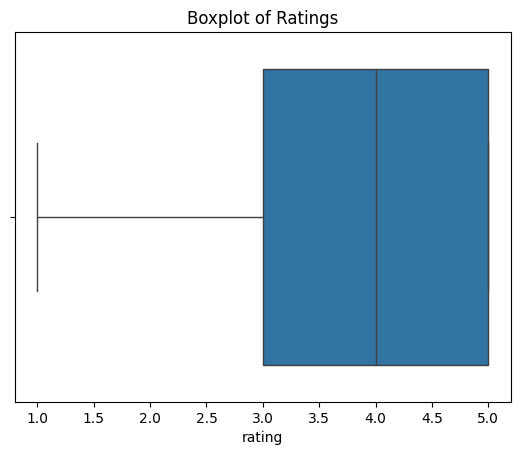

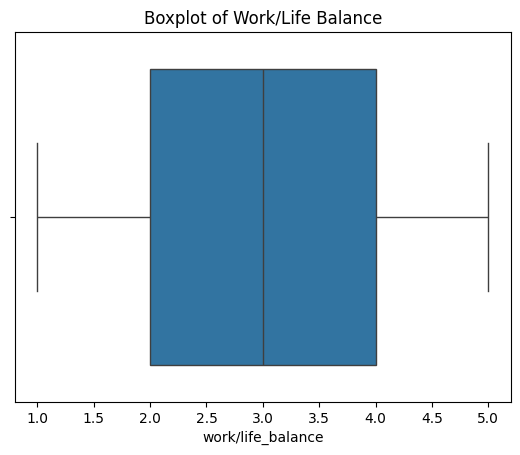

In [147]:
sns.boxplot(x=sampled_reviews['rating'])
plt.title("Boxplot of Ratings")
plt.show()

# Boxplot for 'work/life_balance'
sns.boxplot(x=sampled_reviews['work/life_balance'])
plt.title("Boxplot of Work/Life Balance")
plt.show()

### Yearly trends by an industry

In [204]:
# Grouping by 'industry' and 'year' to calculate mean for each column
industry_trends = sampled_reviews.groupby(['industry', 'year']).agg({
    'pros_sentiment': 'mean',
    'cons_sentiment': 'mean',
    'rating': 'mean',
    'work/life_balance': 'mean',
    'compensation_and_benefits': 'mean',
    'culture_and_values': 'mean',
    'senior_management': 'mean',
    'diversity_and_inclusion': 'mean'
}).reset_index()

industry_trends = industry_trends.round(2)
# Display the resulting aggregated data
display(industry_trends)


,industry,year,pros_sentiment,cons_sentiment,rating,work/life_balance,compensation_and_benefits,culture_and_values,senior_management,diversity_and_inclusion
0,Automotive,2015,0.48,0.01,2.91,2.18,3.13,3.04,2.36,0.00
1,Automotive,2016,0.40,0.01,3.29,2.84,3.27,3.33,2.83,0.00
2,Automotive,2017,0.40,0.03,3.32,2.85,3.41,3.45,3.02,0.00
3,Automotive,2018,0.37,0.00,3.08,2.72,3.42,3.08,2.78,0.00
4,Automotive,2019,0.38,0.00,3.60,3.13,3.49,3.58,3.11,0.00
...,...,...,...,...,...,...,...,...,...,...
130,Transportation_and_Logistics,2019,0.36,0.02,3.50,3.24,3.48,3.43,3.09,0.00
131,Transportation_and_Logistics,2020,0.39,0.01,3.79,3.51,3.70,3.76,3.41,1.13
132,Transportation_and_Logistics,2021,0.41,0.01,3.77,3.30,3.64,3.61,3.33,3.70
133,Transportation_and_Logistics,2022,0.38,-0.00,3.64,3.26,3.50,3.55,3.26,3.80


In [205]:
# Line plot to visualize trends
fig = px.line(industry_trends, 
              x='year', 
              y='rating',  # Change this to another metric if needed
              color='industry',  # This will differentiate industries by color
              title="Average Rating Over the Years by Industry",
              labels={"rating": "Average Rating", "year": "Year", "industry": "Industry"},
              line_group='industry')

# Update layout to make the plot clearer
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Average Rating",
    legend_title="Industry",
    height=600,
    width=1000
)

# Show the plot
fig.show()


### Trends in average rating by Industry

In [230]:
selected_industries = ['Technology', 'Finance', 'Education', 'Healthcare', 'Consumer_Goods', 'Energy', 'Automotive', 'Public_Sector', 'Retail']

# get the filtered data by selected industries
filtered_data = industry_trends[industry_trends['industry'].isin(selected_industries)]

# get the plot with filtered data
fig = px.line(filtered_data, 
              x='year', 
              y='rating',  
              color='industry',  
              title="Yearly trends of Average rating by Industry",
              labels={"rating": "Average Rating", "year": "Year", "industry": "Industry"},
              line_group='industry')

# improve layout
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Average Rating",
    legend_title="Industry",
    height=550,
    width=1000
)

# Show the plot
fig.show()

### Work/Life balance by Industry

In [224]:
selected_industries = ['Technology', 'Finance', 'Education', 'Healthcare', 'Consumer_Goods', 'Energy', 'Automotive', 'Public_Sector', 'Retail']

# get the filtered data by selected industries
filtered_data = industry_trends[industry_trends['industry'].isin(selected_industries)]

# get the plot with filtered data
fig = px.line(filtered_data, 
              x='year', 
              y='work/life_balance',  
              color='industry',  
              title="Work/Life balance by Industry",
              labels={"work/life_balance": "Work/Life Balance", "year": "Year", "industry": "Industry"},
              line_group='industry')

# improve layout
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Work/Life Balance",
    legend_title="Industry",
    height=500,
    width=1000
)

# Show the plot
fig.show()

### Industry sentiment analysis

In [231]:
selected_industries = ['Technology', 'Finance', 'Education', 'Healthcare', 'Consumer_Goods', 'Energy', 'Automotive', 'Public_Sector', 'Retail']

# get the filtered data by selected industries
filtered_data = industry_trends[industry_trends['industry'].isin(selected_industries)]

# get the plot with filtered data
fig = px.line(filtered_data, 
              x='year', 
              y='pros_sentiment',  
              color='industry',  
              title="Pros sentiment by Industry",
              labels={"pros_sentiment": "Pros sentiment", "year": "Year", "industry": "Industry"},
              line_group='industry')

# improve layout
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Pros sentiment",
    legend_title="Industry",
    height=550,
    width=1000
)

# Show the plot
fig.show()

In [229]:
selected_industries = ['Technology', 'Finance', 'Education', 'Healthcare', 'Consumer_Goods', 'Energy', 'Automotive', 'Public_Sector', 'Retail']

# get the filtered data by selected industries
filtered_data = industry_trends[industry_trends['industry'].isin(selected_industries)]

# get the plot with filtered data
fig = px.line(filtered_data, 
              x='year', 
              y='cons_sentiment',  
              color='industry',  
              title="Cons sentiment by Industry",
              labels={"cons_sentiment": "Cons sentiment", "year": "Year", "industry": "Industry"},
              line_group='industry')

# improve layout
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Cons sentiment",
    legend_title="Industry",
    height=500,
    width=1000
)

# Show the plot
fig.show()

In [223]:
# group by 'year' and count the number of reviews
reviews_per_year = sampled_reviews.groupby('year')['review_id'].count().reset_index()
reviews_per_year.columns = ['year', 'number_of_reviews'] # update column names

display(reviews_per_year)
#save csv for further analysis
#reviews_per_year.to_csv("../data/clean/reviews_per_year_sample.csv") 


,year,number_of_reviews
0,2015,8483
1,2016,9118
2,2017,9816
3,2018,9491
4,2019,8348
5,2020,9856
6,2021,20100
7,2022,19282
8,2023,5506
